In [1]:
import sys
import gc
import os
from tqdm import tqdm
import time

import numpy as np
import pickle
import scipy.io as sio
from scipy.io import loadmat
import matplotlib.pyplot as plt
import cv2
import torchvision.transforms as transforms
from PIL import Image


# Pytorch 1.9
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions

# Pytorch3d
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    PointLights,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    TexturesVertex,
    blending
)

import open3d as o3d

# facenet-pytorch 2.5.2
from facenet_pytorch import MTCNN, InceptionResnetV1

# face-alignment 1.3.4
import face_alignment

#######################################
## Setup PyTorch
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
    print('CUDA is available. Device: ', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('CUDA is NOT available. Use CPU instead.')
    


c:\users\yanpe\appdata\local\programs\python\python36\lib\site-packages\numpy\core\__init__.py:29: UserWarning: loaded more than 1 DLL from .libs:
c:\users\yanpe\appdata\local\programs\python\python36\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
c:\users\yanpe\appdata\local\programs\python\python36\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


CUDA is available. Device:  NVIDIA GeForce RTX 3070


torch.Size([1, 30])
(68422, 30)
(68422, 8)
   maximum_facial_width  madibular_width  upper_facial_depth  \
0              0.207528        -0.763301           -1.352298   
1              0.294339         0.164303            0.787344   
2              0.689776         0.673734           -1.451212   
3             -0.872198        -0.956709           -1.486901   
4             -0.652696        -1.391946            0.719659   

   middle_facial_depth  lower_facial_depth  facial_height  \
0            -2.220465           -2.335438      -3.170134   
1             0.864244            0.984531      -0.224183   
2            -0.639017           -0.429705      -1.052893   
3            -2.784148           -3.211969      -1.780318   
4             0.964720           -0.829471       0.385882   

   upper_facial_height  lower_facial_height  
0            -2.725712            -2.487846  
1            -0.498086            -0.585606  
2            -0.475820            -1.046895  
3            -1.30637

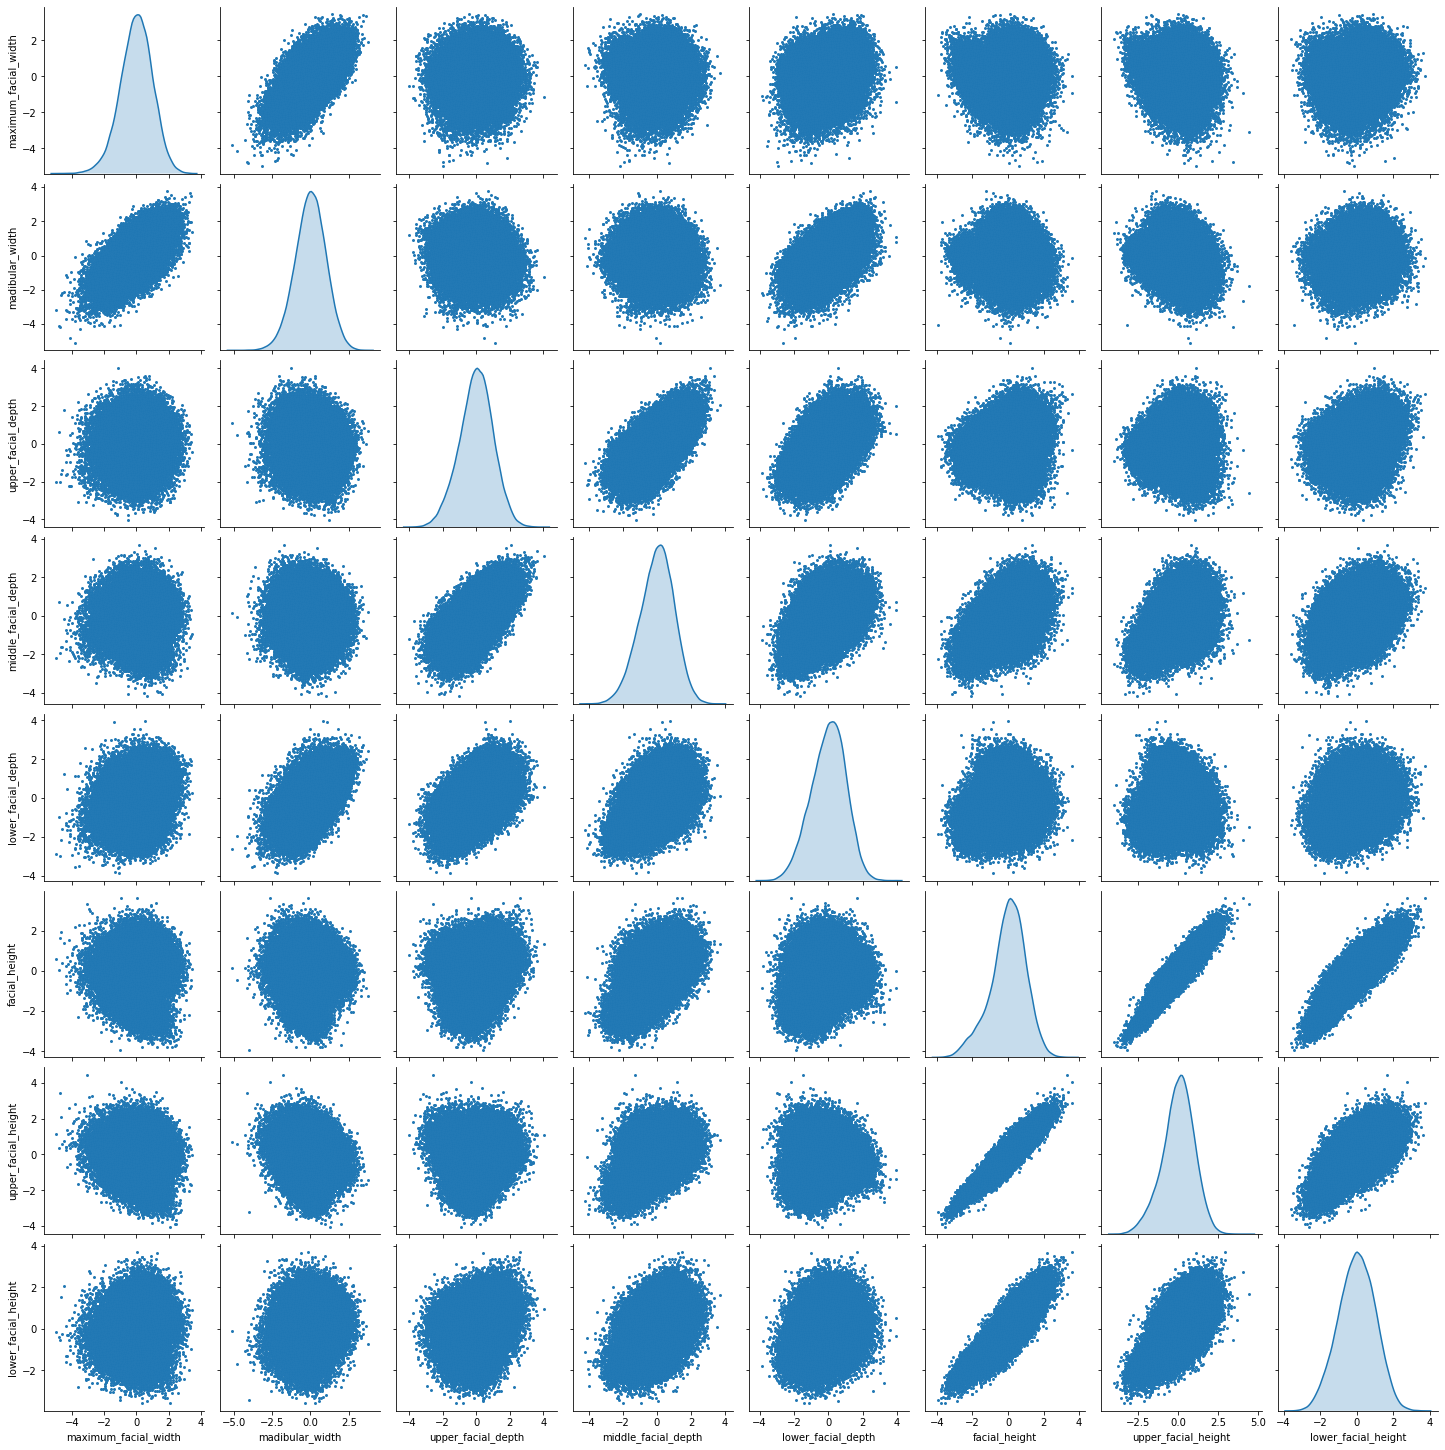

In [19]:
shape_path = '../datasets/FFHQ/raw_bfm_shape/{}.npy'
color_path = '../datasets/FFHQ/raw_bfm_color/{}.npy'


ffhq_meanshape = np.load('./ffhq_meanshape.npy')
file_indices = np.load('./cache/shape_latents/file_indices.npy')


part_name = 'S_overall'


""" Load data """
meanshape_latents = np.load('./cache/meanshape_latents/{}.npy'.format(part_name))
meanshape_latents = torch.from_numpy(meanshape_latents).to(device)
print(meanshape_latents.shape)


latents = np.load('./cache/shape_latents/{}.npy'.format(part_name))
print(latents.shape)

measurements = np.load('./cache/measurements/{}.npy'.format(part_name))
print(measurements.shape)



"""
Min-max normalization
Pros. & Cons.
Guarantees all features will have the exact same scale but does not handle outliers well.
----------------------
normalize to -1 ~ +1
"""
"""
for dim in range(measurements.shape[1]):
    min_ = np.min(measurements[:,dim])
    max_ = np.max(measurements[:,dim])
    measurements[:,dim] = (measurements[:,dim] - min_) / (max_ - min_) # 0 ~ 1
    measurements[:,dim] *= 2 # 0 ~ 2
    measurements[:,dim] -= 1 # -1 ~ 1
""" 
    
"""
Z-score standardization
Pros. & Cons.
Handles outliers, but does not produce normalized data with the exact same scale.
----------------------
0 mean, unit variance
"""
#"""
for dim in range(measurements.shape[1]):
    mean_ = np.mean(measurements[:,dim])
    std_ = np.std(measurements[:,dim])
    measurements[:,dim] = (measurements[:,dim] - mean_) / std_ # 0 mean, unit variance
#"""
    

#########################################################
## Comments:
##
##  I found using z-scoer is much better than min-max
#########################################################

import seaborn as sns
import pandas as pd

measurement_names = [
    'maximum_facial_width',
    'madibular_width',
    'upper_facial_depth',
    'middle_facial_depth',
    'lower_facial_depth',
    'facial_height',
    'upper_facial_height',
    'lower_facial_height'
]
    

d = {
    measurement_names[0]: measurements[:, 0],
    measurement_names[1]: measurements[:, 1],
    measurement_names[2]: measurements[:, 2],
    measurement_names[3]: measurements[:, 3],
    measurement_names[4]: measurements[:, 4],
    measurement_names[5]: measurements[:, 5],
    measurement_names[6]: measurements[:, 6],
    measurement_names[7]: measurements[:, 7],
}


df = pd.DataFrame(data=d)
print(df.head())

_ = sns.pairplot(df, 
                 plot_kws=dict(marker=".", linewidth=0.01), 
                 diag_kind="kde")




In [3]:
"""
 1: face skin
 2: eye brows
 3: eyes
 4: nose
 5: upper lip
 6: lower lip
"""
label_map = {
    'skin': 1,
    'eye_brow': 2,
    'eye': 3,
    'nose': 4,
    'u_lip': 5,
    'l_lip': 6
}

## Load the face parsing labels (per-vertex)
vert_labels = np.load('./BFM09_plus/bfm_vertex_labels.npy')
print(set(vert_labels))


## Load the BFM model
import pickle
with open('./BFM09_plus/bfm09.pkl', 'rb') as f:
    bfm = pickle.load(f)
print('BFM model loaded\n')

## Triangal Facets
Faces = bfm['tri'] - 1 ## -1 is critical !!!

# find the vertices of part
part_vertices = {
    'S_overall':[],
    #'S_rest':[],
    'S_eyebrows':[],
    'S_eyes':[],
    'S_llip':[],
    'S_nose':[],
    'S_ulip':[]
}
for idx in range(len(vert_labels)):
    part_vertices['S_overall'].append(idx)
    if vert_labels[idx] in [label_map['eye_brow']]:
        part_vertices['S_eyebrows'].append(idx)
    if vert_labels[idx] in [label_map['eye']]:
        part_vertices['S_eyes'].append(idx)
    if vert_labels[idx] in [label_map['l_lip']]:
        part_vertices['S_llip'].append(idx)
    if vert_labels[idx] in [label_map['u_lip']]:
        part_vertices['S_ulip'].append(idx)
    if vert_labels[idx] in [label_map['nose']]:
        part_vertices['S_nose'].append(idx)
    
for key in part_vertices:
    part_vertices[key] = np.array(part_vertices[key])
    print(key, ' n_vert: ', len(part_vertices[key]))

{1, 2, 3, 4, 5, 6}
BFM model loaded

S_overall  n_vert:  35709
S_eyebrows  n_vert:  444
S_eyes  n_vert:  586
S_llip  n_vert:  309
S_nose  n_vert:  1711
S_ulip  n_vert:  576


(8, 68422)
(68422, 30)
(8, 30)


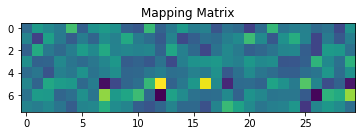

In [4]:
""" 
Solve the linear system via pseudo inverse 
-------------------------------------------
Assume:
                   FM = dZ,
where
     F : measurement matrix of size n x 5
     M : mapping matrix of size 5 x 10
     dZ: matrix of latent offsets of size n x 10
-------------------------------------------
Objective is to find the pseudo inverse of F
to solve the linear system:
                 M = inv(F)dZ
"""
##############
## Find inv(F)
measurements_inv = np.linalg.pinv(measurements) # Moore-Penrose Pseudo Inverse
print(measurements_inv.shape)

##############
## Compute dZ
delta_latents = latents - meanshape_latents.detach().cpu().numpy()
print(delta_latents.shape)

####################################
# Compute the mapping M: shape [6 x 10]
M = measurements_inv @ delta_latents
M = np.array(M, dtype=np.float32)
print(M.shape)
plt.imshow(M)
plt.title('Mapping Matrix')

np.save('./cache/mappings/{}.npy'.format(part_name), M)


M = torch.from_numpy(M).to(device)
def mapping(M, f):
    # input (torch tensor):   measurement with size [1, 6]
    # output (torch tensor):  latent offset with size [1, 10]
    return f @ M
    

In [5]:
class Decoder(nn.Module):
    """part decoder"""
    def __init__(self, latent_dim, n_vert):
        super(Decoder, self).__init__()
        self.n_vert = n_vert
        self.fc1 = nn.Linear(latent_dim, 128)
        self.fc2 = nn.Linear(128, 512)
        self.fc3 = nn.Linear(512, 3*self.n_vert)
        
    def forward(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        x_ = self.fc3(h)
        return torch.reshape(x_, [-1, self.n_vert, 3])
    
part_decoder = Decoder(latent_dim=30, n_vert=len(part_vertices[part_name])).to(device)
part_decoder.load_state_dict(torch.load('../3dmm_local_editing_prototype_3_new/saved_models/part_decoders/{}'.format(part_name)))
print('decoder model on CUDA: ', next(part_decoder.parameters()).is_cuda) # True



decoder model on CUDA:  True


In [15]:

def o3d_render(V, T, Faces, width=512, height=512):
    ###############################
    ## Visualize the render result
    o3d_mesh = o3d.geometry.TriangleMesh()
    o3d_mesh.vertices = o3d.utility.Vector3dVector(V) # dtype vector3d (float)
    o3d_mesh.triangles = o3d.utility.Vector3iVector(Faces) # dtype vector3i (int)
    if T is not None:
        o3d_mesh.vertex_colors = o3d.utility.Vector3dVector(T) # dtype vector3i (int)
        
    if T is None:
        o3d_mesh.compute_vertex_normals() # computing normal will give specular effect while rendering
    
    vis = o3d.visualization.Visualizer()
    vis.create_window(width=width, height=height, visible = False)

    opt = vis.get_render_option()

    ## show Normal if no texture
    #if T is None:
    #    opt.mesh_color_option = o3d.visualization.MeshColorOption.Normal
        
    vis.add_geometry(o3d_mesh)
    ## Smooth shading
    opt.mesh_shade_option = o3d.visualization.MeshShadeOption.Color
    #depth = vis.capture_depth_float_buffer(True)
    image = vis.capture_screen_float_buffer(True)

    return o3d_mesh, image


part_Faces = Faces




maximum_facial_width
-3.0
-2.0
-1.0
0.0
1.0
2.0
3.0


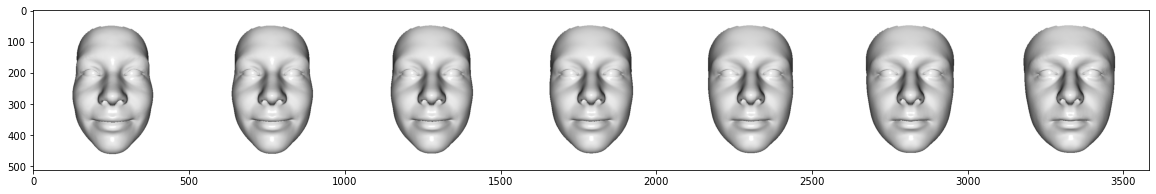

madibular_width
-3.0
-2.0
-1.0
0.0
1.0
2.0
3.0


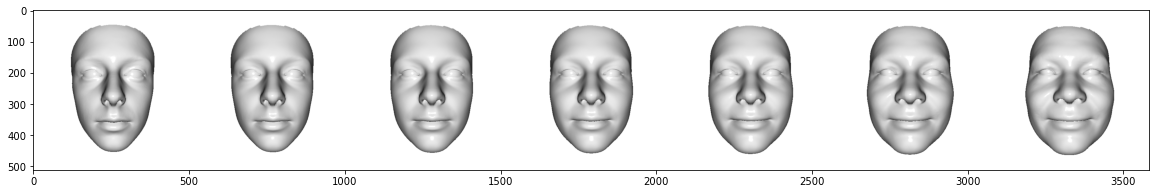

upper_facial_depth
-3.0
-2.0
-1.0
0.0
1.0
2.0
3.0


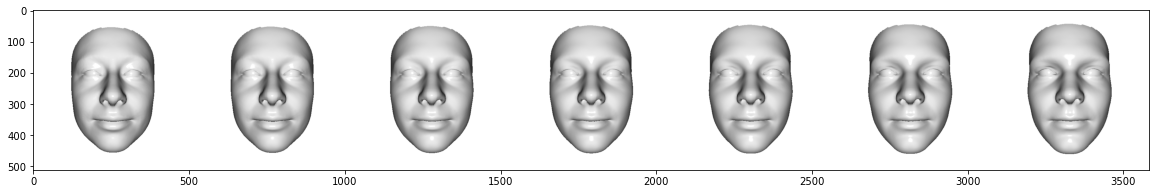

middle_facial_depth
-3.0
-2.0
-1.0
0.0
1.0
2.0
3.0


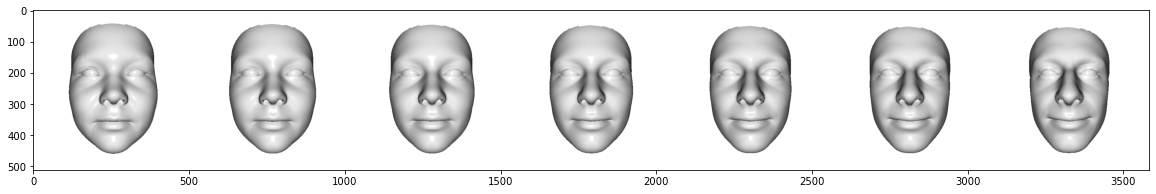

lower_facial_depth
-3.0
-2.0
-1.0
0.0
1.0
2.0
3.0


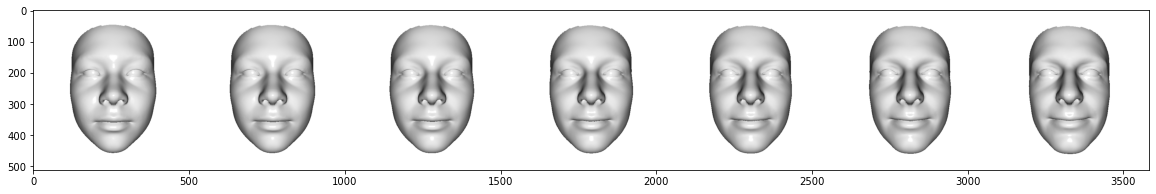

facial_height
-3.0
-2.0
-1.0
0.0
1.0
2.0
3.0


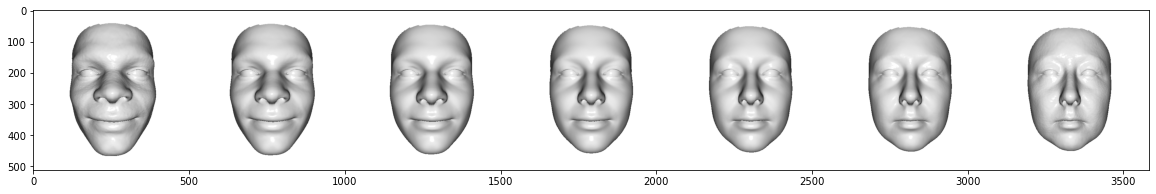

upper_facial_height
-3.0
-2.0
-1.0
0.0
1.0
2.0
3.0


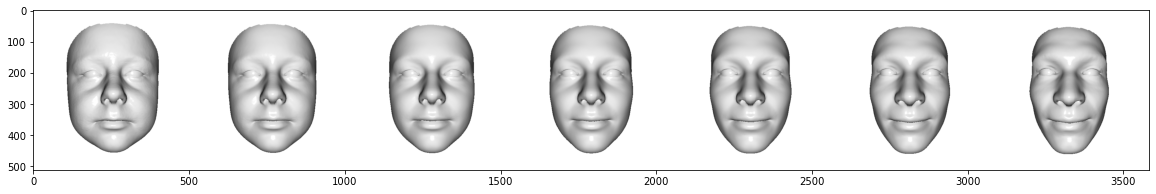

lower_facial_height
-3.0
-2.0
-1.0
0.0
1.0
2.0
3.0


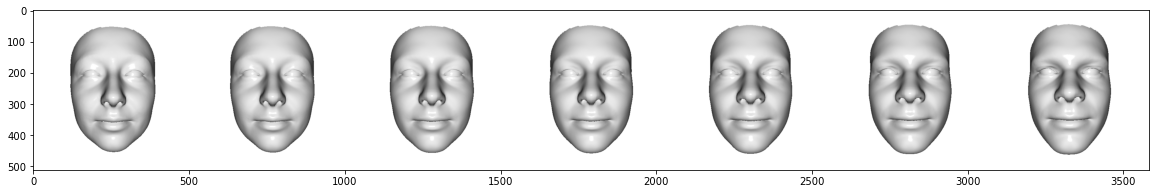

In [48]:
def plot_reconstructed_1dof(mapping, part_decoder, part_V, part_Faces, measurement_dim, r0=(-0.1, 0.1), dim=0, n=3):
    w = 512
    img = np.zeros((w, n*w, 3))
    for j, x in enumerate(np.linspace(*r0, n)):
        f = torch.zeros([1, measurement_dim]).to(device)
        f[0,dim] = x
        
        latent_offset = mapping(M, f).to(device)
        new_latent = meanshape_latents + latent_offset
        
        new_shape = part_decoder(new_latent)[0].detach().cpu().numpy()

        V = np.zeros([35709, 3], dtype=np.float32)
        V = new_shape

        _, image = o3d_render(V, None, part_Faces)
        
        img[0:w, j*w:(j+1)*w] = image
    plt.figure(figsize=(20,10))
    plt.imshow(img)
    plt.show()
    

for dimension in range(len(measurement_names)):
    print(measurement_names[dimension])
    plot_reconstructed_1dof(mapping, part_decoder, part_vertices[part_name], part_Faces,
                            measurement_dim=len(measurement_names), r0=(-3, 3), dim=dimension, n=7)

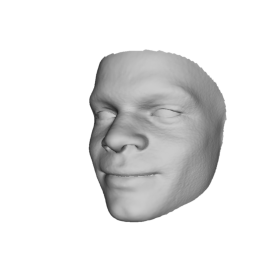

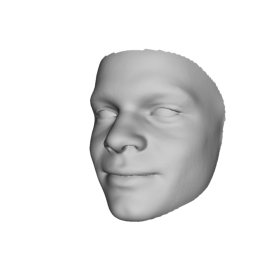

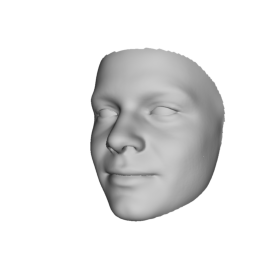

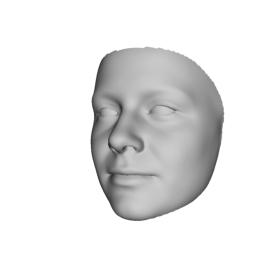

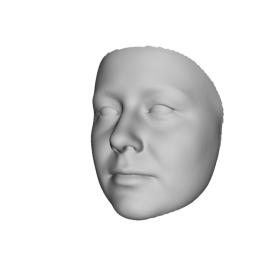

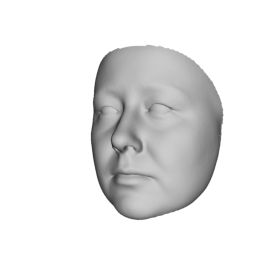

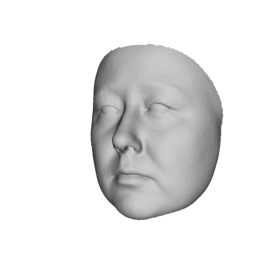

In [47]:
# Facial Height
measurement_dim=len(measurement_names)
dim = 5 # Facial Height


#_, image = o3d_render(V, None, part_Faces)

def rotation_matrix(yaw):
    import math
    """ Compute the rotation matrix """
    ## 0 <= yaw <= 3.14 
    Ry = np.array([[math.cos(yaw), 0, math.sin(yaw)],
                   [0, 1, 0],
                   [-math.sin(yaw), 0, math.cos(yaw)]],)
    return Ry


###############################
## Visualize the render result
# Initialize a camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction. 
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow. 
R, T = look_at_view_transform(3.7, 0, 180) 
cameras = FoVPerspectiveCameras(device=device, R=R, T=T, fov=40.0)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=1024, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# -z direction. 
#lights = PointLights(device=device, location=[[0.0, 0.0, -1e5]])
lights = PointLights(device=device, location=[[0.0, 0.0, -1e5]], ambient_color=[[0, 0, 0]],
                     specular_color=[[0., 0., 0.]], diffuse_color=[[1., 1., 1.]])

# Create a Phong renderer by composing a rasterizer and a shader. The textured Phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)
tri = torch.from_numpy(Faces).to(device)[None]


C = {
    '-3': -3,
    '-2': -2,
    '-1': -1,
    '0': 0,
    '+1': +1,
    '+2': +2,
    '+3': +3
}

for s in C:
    c = C[s]
    f = torch.zeros([1, measurement_dim]).to(device)
    f[0,dim] = c

    latent_offset = mapping(M, f).to(device)
    new_latent = meanshape_latents + latent_offset

    new_shape = part_decoder(new_latent)[0].detach().cpu().numpy()

    V = np.zeros([35709, 3], dtype=np.float32)
    V = new_shape

    R = rotation_matrix(3.6)
    V = V @ R
    V = np.array(V, dtype=np.float32)
    V = torch.from_numpy(V).to(device)[None]

    T = np.zeros([35709,3], dtype=np.float32)
    T[...] = 0.8

    face_color = TexturesVertex(torch.from_numpy(T).to(device)[None])

    mesh = Meshes(V, tri.repeat(1, 1, 1), face_color)
    images = renderer(mesh)
    img = images[0,...,:3].cpu().numpy()

    plt.imshow(img)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig('{}_sigma_facial_height_VAE.png'.format(s), dpi=300, bbox_inches='tight')  
    plt.show()



